In [1]:
function [X_norm, mu, sigma] = featureNormalize(X)
    mu = mean(X);
    sigma = std(X);
    sigma(sigma==0)=1;   
    X_norm = [(X - mu) ./ sigma];
end

In [2]:
function [X_norm, mu, sigma] = featureNormalize2(X)
    mu = mean(X);
    sigma = std(X);
    sigma(sigma==0)=1;   
    ix_norm = sigma > 10;
    X_norm = X;

    if sum(ix_norm) > 0
        X_norm(:,ix_norm) = [(X(:,ix_norm) - mu(ix_norm)) ./ sigma(ix_norm)];
    end
end

In [3]:
function opts = init_opts(opts)
    if ~isfield(opts, 'rho')
        opts.rho = 10;
    end 
    
    if ~isfield(opts, 'lambda')
        opts.lambda = 5; 
    end
    
    if ~isfield(opts, 'c')
        opts.c = 1; 
    end
    
    if ~isfield(opts, 'lr')
        opts.lr = 10^-3;
    end
    
    if ~isfield(opts, 'optimizer')
        opts.optimizer = 3;
    end
    
    if ~isfield(opts, 'max_iters')
        opts.max_iters = 1000;
    end
    
    if ~isfield(opts, 'tol')
        opts.tol = 10^-4;
    end
    
    if ~isfield(opts, 'scaling')
        opts.scaling = 1; % 1 is Z normal scaling, 2 is min max scaling
    end
        
    if ~isfield(opts, 'tflag')
        opts.tflag = 1; % percentage change
    end

end

In [4]:
function ut = updateU(X, Y, W, U, L, t, lambda, rho, c)
    T = length(X);
    xt = X{t};
    yt = Y{t};
    wt = W(:,t);
    ut = U(:,t);
    lt = L(:,t);
    d = size(xt, 2);   
    
    if rho != 0
    if t == 1 
        utn = U(:,t+1);
        slackGrad = ut .* utn;
        ut(slackGrad >= 0) = wt(slackGrad >= 0) + 1/(rho) * lt(slackGrad >= 0);
        ut(slackGrad < 0) = wt(slackGrad < 0) + 1/(rho) * ( c*utn(slackGrad < 0) + lt(slackGrad < 0) );
    elseif t == T
        utp = U(:,t-1);  
        slackGrad = ut .* utp;
        ut(slackGrad >= 0) = wt(slackGrad >= 0) + 1/(rho) * lt(slackGrad >= 0);
        ut(slackGrad < 0) = wt(slackGrad < 0) + 1/(rho) * (c*utp(slackGrad < 0) + lt(slackGrad < 0) );    
    else
        utp = U(:,t-1);
        utn = U(:,t+1);        
        slackGrad1 = ut .* utn;
        slackGrad2 = ut .* utp;
        
        ix = slackGrad1 >= 0 & slackGrad2 >= 0;
        ut(ix) = wt(ix) + 1/(rho) * lt(ix) ;
        
        ix = slackGrad1 >= 0 & slackGrad2 < 0;
        ut(ix) = wt(ix) + 1/(rho) * ( c*utp(ix) + lt(ix) );   
        
        ix = slackGrad1 < 0  & slackGrad2 >= 0;
        ut(ix) = wt(ix) + 1/(rho) * ( c*utn(ix) + lt(ix) );
        
        ix = slackGrad1 < 0  & slackGrad2 < 0;
        ut(ix) = wt(ix) + 1/(rho) * ( c*utp(ix) +  c*utn(ix) + lt(ix) );
    end
    end

end

In [5]:
function [J,grad] = computeGradients(X, Y, W, U, L, t, lambda, rho, c)
    T = length(X);
    xt = X{t};
    yt = Y{t};
    wt = W(:,t);
    ut = U(:,t); 
    lt = L(:,t);
    [m, d] = size(xt);
    
    yt_hat = xt*wt;
    yt_error = yt_hat-yt;
    least = 1/(2*m) * sum(yt_error.^2);
    reg = lambda/(2*m) * sum(wt.^2);

    if t == 1
        utn = U(:,t+1);
        slack = c * sum(max(0, - ut.*utn));
    elseif t < T
        utp = U(:,t-1);
        utn = U(:,t+1);
        slack = c * (sum(max(0, - ut.*utp)) + sum(max(0, - ut.*utn)));
    else
        utp = U(:,t-1);
        slack = c * sum(max(0, - ut.*utp));
    end
    
    J = least + reg + slack;    
    if rho!= 0 
        lagrange_grad = rho*(wt-ut+ lt/rho);
    else
        lagrange_grad = 0;
    end
    grad = (1/m)*(yt_error'*xt)' + lambda/m*wt + lagrange_grad;
end

In [6]:
function [wt, jt] = minimizeJ(X, Y, W, U, L, t, i,opts)
    T = length(X);
    xt = X{t};
    yt = Y{t};
    wt = W(:,t);
    ut = U(:,t); 
    lt = L(:,t);
    [m, d] = size(xt);

    % momentum
    mlr_V = ones(d,1);     
    mlr_mu = 0.9;
    mlr_alpha = opts.lr;
    % accelerated gradient
    nag_V = ones(d,1);
    nag_mu = 0.9;
    nag_alpha = opts.lr;
    % adagrad
    % rmsprop
    rmsprop_gamma = 0.01;
    rmsprop_r=wt;


    for iter = 1:opts.max_iters
%        fprintf('\r iter: %d task: %d training iter: %d ',i, t, iter);
    
        if opts.optimizer == 3
            nag_W = W + nag_mu * nag_V;
            [cost, grad_W] = computeGradients(X, Y, nag_W, U, L, t,  opts.lambda, opts.rho, opts.c);
        else
            [cost, grad_W] = computeGradients(X, Y, W, U, L, t,  opts.lambda, opts.rho, opts.c);
        end
        
        if opts.optimizer == 1 % GD
            W(:, t) = W(:, t) - opts.lr * grad_W;
        elseif opts.optimizer == 2 % momentum GD
            mlr_V(:, t) = mlr_mu * mlr_V(:, t) - mlr_alpha * grad_W;
            W(:, t) = W(:, t) + mlr_V(:, t);
        elseif opts.optimizer == 3 % NAG
            nag_V(:, t) = nag_mu * nag_V(:, t) - nag_alpha * grad_W;
            W(:, t) = W(:, t) + nag_V(:, t);
        elseif opts.optimizer == 4
            adagrad_hist(iter,:) = grad_W;
            adagrad_W = grad_W ./ sqrt(sum(adagrad_hist.^2))';
            W(:, t) = W(:, t) - opts.lr * adagrad_W;
        elseif opts.optimizer == 5 % rmsprop
            %size(rmsprop_r), size(grad_W)
            rmsprop_r = rmsprop_gamma*rmsprop_r + (1-rmsprop_gamma)*grad_W.^2;
            W(:, t) = W(:, t) - opts.lr * grad_W./ sqrt(rmsprop_r);
        end   
            
        J_history(iter) = cost;
        
        if iter >1 
            prev_hist = J_history(iter-1);
            curr_hist = J_history(iter);

            if opts.tflag == 1
                delta_hist(iter) = abs(prev_hist - curr_hist) ./ prev_hist;
                if sum(delta_hist(end) > opts.tol) == 0
                    break
                end                                
            elseif opts.tflag == 2
                delta_hist(iter) = abs(prev_hist - curr_hist);                
                if sum(delta_hist(end) > opts.tol) == 0
                    break
                end
            else # 0 : not stop criteria
                delta_hist(iter) = abs(prev_hist - curr_hist);
            end
        end
    
    end
    
    wt = W(:,t);
    jt = J_history;
    
end

In [7]:
function [W, J_hist, J_hist_all, primal_residual_val, primal, dual_residual_val, dual] = Least_SWMTL3(X, Y, opts)

    % hyperparameters
    opts = init_opts(opts) ;  

    % data variables
    T = length(X);
    d = size(X{1},2);   
    
    if opts.scaling
        %d = d + 1;
        d = d;
    end
    
    % output variables
    if isfield(opts, 'W0')
        W = opts.W0;
    else
        W = rand(d,T);     
    end

    % internal variables
    U = W;
    L = W;

    
    % data normalization
    if opts.scaling
        disp('scaling data')
        for t=1:T 
            if opts.scaling == 1
                [X{t}, mu_X(:,t), sigma_X(:,t)] = featureNormalize(X{t});
                [Y{t}, mu_Y(:,t), sigma_Y(:,t)] = featureNormalize(Y{t});
            elseif opts.scaling == 2
                [X{t}, mu_X(:,t), sigma_X(:,t)] = featureNormalize2(X{t});
                [Y{t}, mu_Y(:,t), sigma_Y(:,t)] = featureNormalize2(Y{t});
            end
        end
    end
    
    %init history
    disp('initializing hist')
    for t=1:T
        J_hist{t} =[];
    end
        
    
    i = 1; % the iteration counter
    while i <= opts.max_iters 

        U_previous = U;
        
        J_hist_all(i) = 0;
        
        for t = 1:T        
            [wt, jt]=minimizeJ(X, Y, W, U, L, t,i, opts);            
            W(:, t) = wt;
            J_hist{t} = vertcat([J_hist{t}, jt]);            
            last_cost= J_hist{t}(end);
            J_hist_all(i) = J_hist_all(i) + last_cost;
            
            fprintf('\r iter: %d task: %d cost: %d' ,i, t, last_cost);
        end
        
        for t = 1:T
            U(:,t) = updateU(X, Y, W, U, L, t, opts.lambda, opts.rho, opts.c);                                
        end


        primal_residual = W - U ;
        dual_residual = -opts.rho * (U - U_previous);
        primal_residual_val{i} = primal_residual;
        primal(i) = sqrt(sum(sum(primal_residual.^2)));
        dual_residual_val{i} = dual_residual;
        dual(i) = sqrt(sum(sum(dual_residual.^2)));
            
        % stop criteria
        if i > 1 
            prev_hist = J_hist_all(end-1);
            curr_hist = J_hist_all(end);

            if opts.tflag == 1
                delta_hist = abs(prev_hist - curr_hist) ./ prev_hist;
                if (delta_hist > opts.tol) == 0
                    break
                end                                
            elseif opts.tflag == 2
                delta_hist = abs(prev_hist - curr_hist);                
                if (delta_hist > opts.tol) == 0
                    break
                end
            else
                delta_hist = abs(prev_hist - curr_hist);
            end
        end
        
        
        L = L + opts.rho*(W-U);
        i = i + 1;

    end
        
    if opts.scaling == 1
        W=[W./sigma_X.*sigma_Y];             
    elseif opts.scaling == 2
        ix_sigma = sigma_X > 10;
        size(ix_sigma)
        W(ix_sigma)=W(ix_sigma)./sigma_X(ix_sigma).*(sigma_Y.*ones(size(W)))(ix_sigma);              
    end

end

In [69]:
!ls ../data/multilingual

venezuela.mat		venezuela2014.mat



# 1D dataset

In [71]:
clear;
load ../data/multilingual/venezuela.mat
X = Xs;
T = length(X);
whos

Variables in the current scope:

   Attr Name           Size                     Bytes  Class
   ==== ====           ====                     =====  ===== 
        T              1x1                          8  double
        X              1x3                   32108200  cell
        Xs             1x3                   32108200  cell
        Y          27375x1                     219000  double
        keywords       1x1                      16167  struct
        langs          1x3                         24  cell
        locations      1x75                      2080  cell

Total is 27461 elements using 64453679 bytes



error: matrix cannot be indexed with {


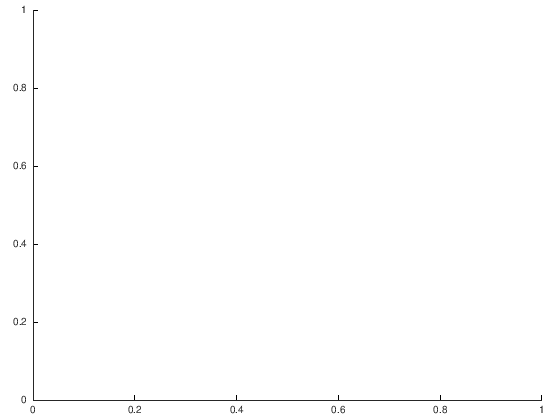

In [72]:
% clf ;
hold on;
    
for t=1:T
    plot(X{t}(:,1), Y{t} , '.' );
    %text(mean(X{t}(:,1)), mean(Y{t}), num2str(t), 'fontsize', 14)
end

## normalize data

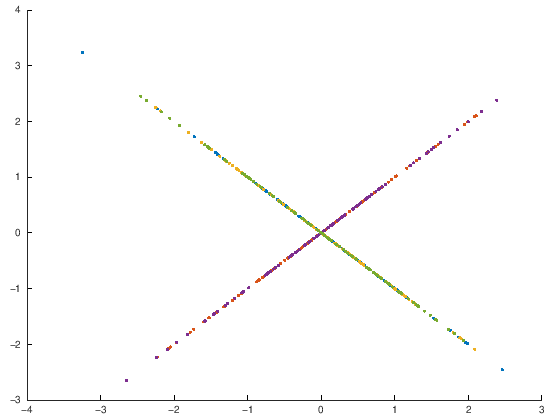

In [234]:
hold on;

for t=1:T
    % normalize data
    [X_norm{t}, muv, sigmav] = featureNormalize(X{t});
    mu{t} = muv';
    sigma{t}= sigmav';
    [Y_norm{t}, y_muv, y_sigmav] = featureNormalize(Y{t});
    y_mu{t}=y_muv';
    y_sigma{t}=y_sigmav';
    plot(X_norm{t}(:,1), Y_norm{t} , '.' )
    #text(mean(X_norm{t}(:,1)), mean(y_norm{t}), num2str(t), 'fontsize', 14);
end

In [274]:
opts = struct('rho', 7, 'lambda', 10^-4, 'c', 10^-5, ...
    'lr', 0.1, 'tol', 10^-5, 'scaling', 1, ...
    'optimizer', 4, 'tflag', 0, 'max_iters', 50)
    
[w , obj_history, J_history_all ,primal_residual_val, primal, dual_residual_val, dual] = Least_SWMTL3(X, Y, opts);

opts =

  scalar structure containing the fields:

    rho =  7
    lambda =  0.00010000
    c =  0.000010000
    lr =  0.10000
    tol =  0.000010000
    scaling =  1
    optimizer =  4
    tflag = 0
    max_iters =  50

scaling data
initializing hist
 iter: 50 task: 5 cost: 1.24376e-05

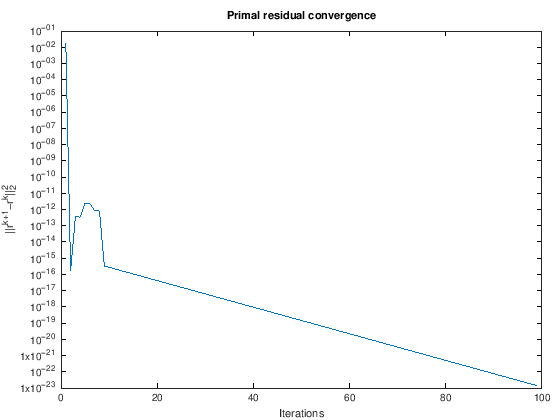

In [270]:
p_res = [];
for i = 1:(size(primal_residual_val,2)-1)
    p_res(i) = sum(sum((primal_residual_val{i+1} - primal_residual_val{i}).^2));
end

semilogy(p_res);
title('Primal residual convergence');
ylabel('||r^{k+1}-r^{k}||_2^2');
xlabel('Iterations');

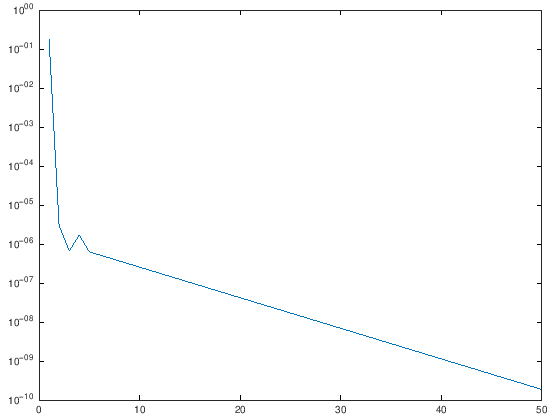

In [254]:
semilogy(primal);

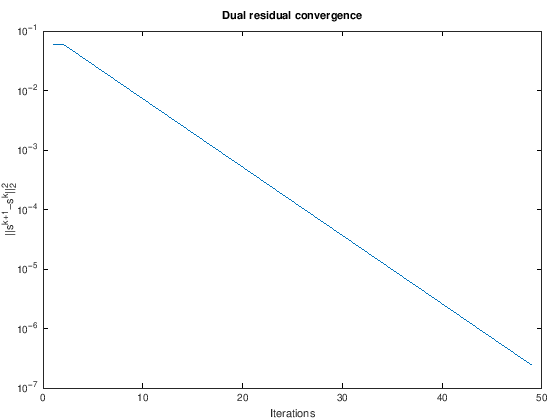

In [275]:
r_res = [];
for i = 1:(size(dual_residual_val,2)-1)
    r_res(i) = sum(sum((dual_residual_val{i+1} - dual_residual_val{i}).^2));
end

semilogy(r_res);
title('Dual residual convergence');
ylabel('||s^{k+1}-s^k||_2^2');
xlabel('Iterations');

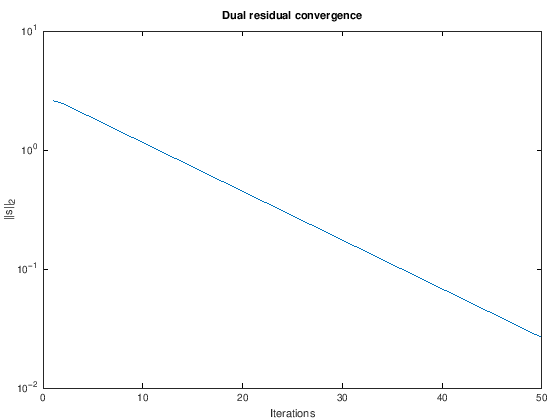

In [268]:
semilogy(dual);
title('Dual residual convergence');
ylabel('||s||_2');
xlabel('Iterations');

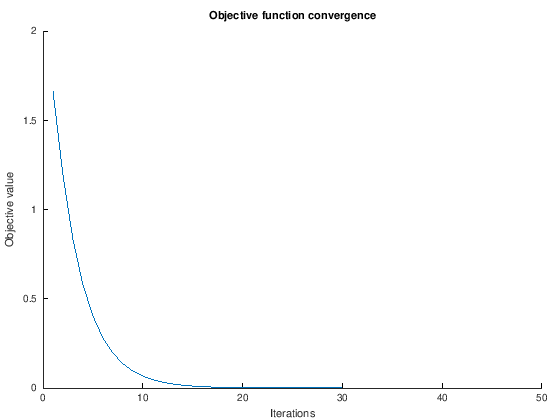

In [260]:
hold on;
plot(J_history_all)
title('Objective function convergence');
ylabel('Objective value');
xlabel('Iterations');

### Sensitivity Analysis - rho

In [14]:
j = 0;
for i = [5*10^(-3) 10^(-2) 5*10^(-2) 0.1 0.5 1 5 10]
    j = j + 1;
    opts = struct('rho', i, 'lambda', 0.1, 'c', 0.001, ...
    'lr', 0.01, 'tol', 10^-4, 'scaling', 1, ...
    'optimizer', 4, 'tflag', 1, 'max_iters', 100);
    
    [w , obj_history, J_history_all ,primal_residual_val, dual_residual_val] = Least_SWMTL3(X, Y, opts);
    N = size(J_history_all,2);
    sensitivity_rho(j) = J_history_all(N);
end

scaling data
initializing hist
 iter: 100 task: 20 cost: 0.000504946scaling data
initializing hist
 iter: 100 task: 20 cost: 0.000458312scaling data
initializing hist
 iter: 100 task: 20 cost: 0.000455607scaling data
initializing hist
 iter: 17 task: 20 cost: 0.000455623scaling data
initializing hist
 iter: 14 task: 20 cost: 0.00045565scaling data
initializing hist
 iter: 19 task: 20 cost: 0.000455528scaling data
initializing hist
 iter: 58 task: 20 cost: 0.000455749scaling data
initializing hist
 iter: 100 task: 20 cost: 0.000456173

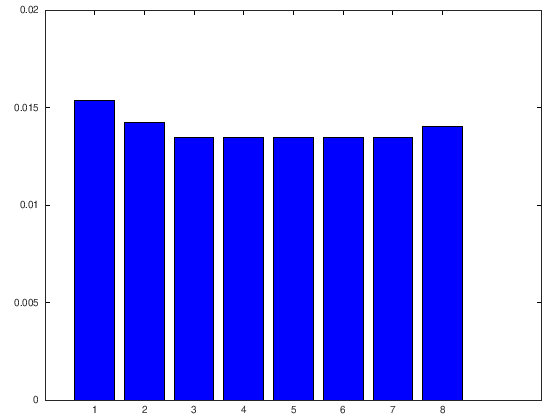

In [20]:
x = [5*10^(-3) 10^(-2) 5*10^(-2) 0.1 0.5 1 5 10];

bar(sensitivity_rho, 'b');

### Sensitivity Analysis - lambda

In [16]:
j = 0;
sensitivity_lambda = [];
for i = [10^-4 5*10^-4 10^(-3) 5*10^(-3) 10^(-2) 5*10^(-2) 0.1 0.5]
    j = j + 1;
    opts = struct('rho', 1, 'lambda', i, 'c', 0.001, ...
    'lr', 0.01, 'tol', 10^-4, 'scaling', 1, ...
    'optimizer', 4, 'tflag', 1, 'max_iters', 100);
    
    [w , obj_history, J_history_all ,primal_residual_val, dual_residual_val] = Least_SWMTL3(X, Y, opts);
    N = size(J_history_all,2);
    sensitivity_lambda(j) = J_history_all(N);
end

scaling data
initializing hist
 iter: 21 task: 20 cost: 0.000360703scaling data
initializing hist
 iter: 19 task: 20 cost: 0.000361196scaling data
initializing hist
 iter: 20 task: 20 cost: 0.000361569scaling data
initializing hist
 iter: 19 task: 20 cost: 0.00036539scaling data
initializing hist
 iter: 20 task: 20 cost: 0.000370159scaling data
initializing hist
 iter: 20 task: 20 cost: 0.000408165scaling data
initializing hist
 iter: 21 task: 20 cost: 0.000455644scaling data
initializing hist
 iter: 19 task: 20 cost: 0.000835327

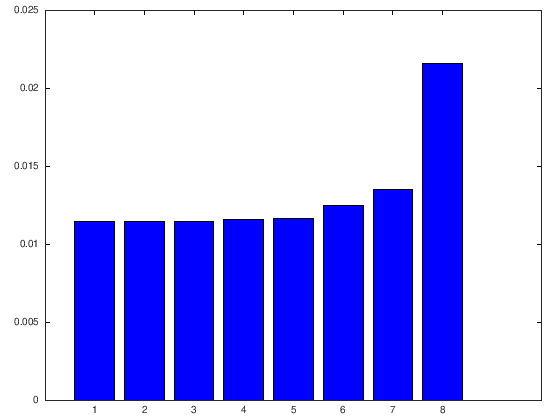

In [21]:
x = [10^-4 5*10^-4 10^(-3) 5*10^(-3) 10^(-2) 5*10^(-2) 0.1 0.5 1];

bar(sensitivity_lambda, 'b');

### Sensitivity Analysis - c

In [18]:
j = 0;
for i = [10^-5 5*10^(-5) 10^(-4) 5*10^(-4) 10^(-3) 5*10^(-3) 10^(-2) 5*10^-2]
    j = j + 1;
    opts = struct('rho', 1, 'lambda', 0.1, 'c', i, ...
    'lr', 0.01, 'tol', 10^-4, 'scaling', 1, ...
    'optimizer', 4, 'tflag', 1, 'max_iters', 100);
    
    [w , obj_history, J_history_all ,primal_residual_val, dual_residual_val] = Least_SWMTL3(X, Y, opts);
    N = size(J_history_all,2);
    sensitivity_c(j) = J_history_all(N);
end

scaling data
initializing hist
 iter: 22 task: 20 cost: 9.87986e-05scaling data
initializing hist
 iter: 20 task: 20 cost: 0.000113285scaling data
initializing hist
 iter: 23 task: 20 cost: 0.000131309scaling data
initializing hist
 iter: 21 task: 20 cost: 0.0002757scaling data
initializing hist
 iter: 22 task: 20 cost: 0.000455582scaling data
initializing hist
 iter: 100 task: 20 cost: 0.0018779scaling data
initializing hist
 iter: 71 task: 20 cost: 0.00361274scaling data
initializing hist
 iter: 21 task: 20 cost: 0.0159675

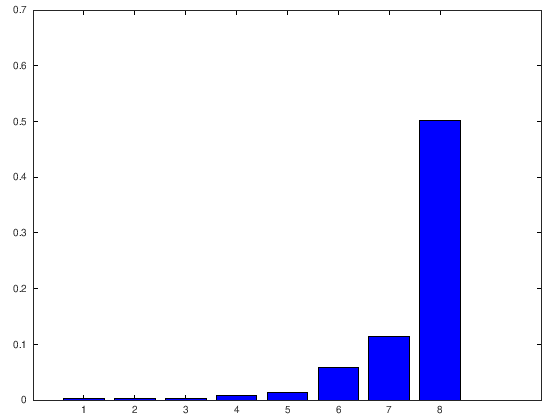

In [31]:
x = [10^-5 5*10^(-5) 10^(-4) 5*10^(-4) 10^(-3) 5*10^(-3) 10^(-2) 5*10^-2];
bar(sensitivity_c, 'b');

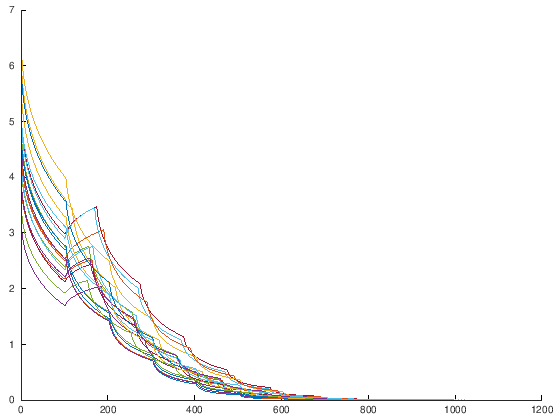

In [28]:
hold on;

for t=1:T
    %semilogy(pr(3:end), 'DisplayName', ['L' num2str(t)])
    plot(obj_history{t}, 'DisplayName', ['L' num2str(t)])
    #plot(primal_residual_val{t}, 'DisplayName', ['L' num2str(t)])
end

%legend;
% figure(1, 'position',[0,0,1000,500]);

% subplot(1,2,1)
% plot(pr)
% subplot(1,2,2)
% plot(dr)


In [88]:
[w(1:5,1:3), cell2mat(W)(1:5,1:3)]

error: w(_,3): but w has size 17x2


In [89]:
% figure(1, 'position',[0,0,500,2500]);

% for t=1:5
%     subplot(T,1, t)
%     scatter(X{t}(:,1), Y{t}, 'b' , 's')
%     hold on
%     m = size(X{t},1);
%     %Y_hat{t} = X{t} * w(:, t);
%     Y_hat{t} = X{t} * w_hat(:, t);
%     %Y_hat{t} = [ones(m,1) X_norm{t}] * w(:, t);
%     scatter(X{t}(:,1), Y_hat{t}, 'r')
% end

In [136]:
addpath('../src/utils/');
addpath('../src/models/');

In [137]:
train_size=0.6
random_state=7
[X_train, Y_train, X_test, Y_test] = datasplit(X, Y, train_size, random_state);

train_size =  0.60000
random_state =  7


In [161]:
% scaling =  1
%     tol =  0.0010000
%     lr =  0.010000
%     optimizer =  4
%     max_iters =  100
%     lambda =  0.00056234
%     rho =  0.10000
%     c =  0.000010000
    
opts = struct('rho', 1, 'lambda', 0.1, 'c', 0.000010000, ...
    'lr', 0.1, 'tol', 0.01, 'scaling', 2, ...
    'optimizer',4, 'tflag', 1, 'max_iters', 100)
    
[w , obj_history] = Least_SWMTL3(X, Y, opts);



opts =

  scalar structure containing the fields:

    rho =  1
    lambda =  0.10000
    c =  0.000010000
    lr =  0.10000
    tol =  0.010000
    scaling =  2
    optimizer =  4
    tflag =  1
    max_iters =  100

scaling data
initializing hist
 iter: 2 task: 5 cost: 28.9343ans =

   617     5



In [162]:
[w(1:10,1:2), cell2mat(W)(1:10,1:2)]

error: 'W' undefined near line 1 column 24


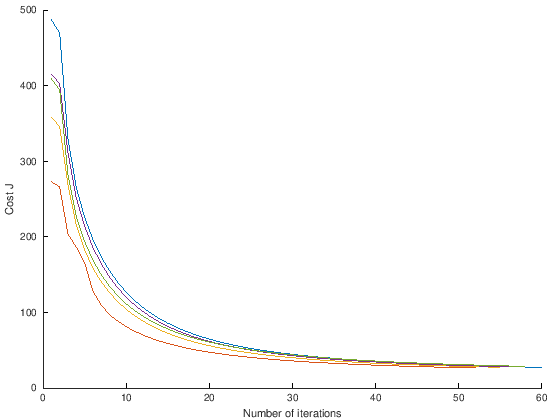

In [163]:

hold on;

for t=1:T
    %semilogy(pr(3:end), 'DisplayName', ['L' num2str(t)])
    plot(obj_history{t}, 'DisplayName', ['L' num2str(t)])
    %break
end

xlabel('Number of iterations');
ylabel('Cost J');

In [164]:
[MSE, MSLE, MAE, EV, R2] = mtreg_test(w,X_test,Y_test, opts)

MSE =  75.096
MSLE =  1.1382
MAE =  6.8826
EV = -0.063869
R2 = -0.30909


In [96]:
w

w =

   0.843296   0.563774
   0.498820   0.332715
   0.678104  -0.182705
   0.676817   0.502267
   0.070158   0.250005
   0.450466   0.597702
  -0.015453   0.575951
   0.175420   0.689130
   0.491045   0.089320
  -0.018652   1.216541
   0.144685   0.651978
  -0.016998   0.975693
   0.687066   1.134800
   0.423318   0.157998
   0.633235   0.225588
   0.527245   0.900257
   0.434308   0.017885

